In [1]:
# import cudf as pd
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# df = pd.read_csv("llamacpp.llama8b.trace.3conversation_no_cachedrop.log)
# df = pd.read_csv("results/retval/llamacpp.llama8b.trace.1717683027-1talk.log")
# df = pd.read_csv("results/retval/llamacpp.llama8b.trace.1717683171-3talk.log")
df = pd.read_csv("results/retval/no_prefetch/llamacpp.llama8b.trace.1718674620.log")
df = df.dropna()

/tmp/ipykernel_3646025/4111640911.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("results/retval/no_prefetch/llamacpp.llama8b.trace.1718674620.log")


In [3]:
df['time'] = df["time"].astype("int")
df["flags"] = df["flags"].astype("int").parallel_apply(lambda x: f"{bin(x)[2:]}".ljust(10, "0")).astype("str")
df["retval"] = df["retval"].astype("int").parallel_apply(lambda x: f"{hex(x)}").astype("str")

In [4]:
df

,pid,name,addr,flags,time,retval
0,3628119,bpftrace,0x56055bd84c60,1001010101,5000,0x0
1,3628139,bpftrace,0x7f71e36eb080,1101010100,10600,0x100
2,3628139,bpftrace,0x7fffffffefea,1000000100,11669,0x0
3,3628139,sudo,0x556a79e2f278,1000010101,8849,0x200
4,3628139,sudo,0x7fdf3a689110,1000010101,4850,0x200
...,...,...,...,...,...,...
3716597,2888257,node,0x7f2ce2d51bd0,1001010101,970,0x0
3716598,2888257,node,0x21a505a8d1d8,1001010101,1060,0x0
3716599,3628119,bpftrace,0x56055cd66e7c,1001010101,5340,0x0
3716600,3628119,bpftrace,0x56055cf34620,1001010100,84939,0x0


In [5]:
df["name"].value_counts()

name
main               2263326
loginctl            664569
node                333090
ps                  169940
cpuUsage.sh         121226
cat                  50562
sh                   23117
btop                 17613
rustdesk             14119
sed                  14081
cuda-EvtHandlr        8401
which                 7966
btm                   6592
sleep                 4854
tailscaled            4224
systemd-journal       3877
cpptools              2821
zsh                   1571
dbus-daemon            667
sudo                   630
starship               575
bash                   558
unity-greeter          494
gdbus                  417
git                    197
bpftrace               176
tokio-runtime-w        171
rshim                  163
polkitd                156
flexi_logger-fl        117
dockerd                104
flexi_logger-fs         60
gmain                   47
snapd                   30
cups-browsed            27
cpptools-srv            19
sshd                   

In [7]:
# 过滤掉其他附带的程序
df = df[df["name"] == "main"]
df = df.reset_index().drop(columns=["index"])

In [8]:
df["name"].value_counts()

name
main    2263326
Name: count, dtype: int64

In [9]:
df["retval"].value_counts()

retval
0x0      1212696
0x100     790314
0x400     192025
0x200      47174
0x404      21028
0x300         89
Name: count, dtype: int64

# 虚拟地址转换成pfn

In [10]:
df["pfn"] = df["addr"].apply(lambda x: int(x, 16))
df["pfn"] = df["pfn"].parallel_apply(lambda x: (x - df["pfn"].min()) // (4 * 1024))
df["pfn"] = df["pfn"].astype("int")

In [12]:
df

,pid,name,addr,flags,time,retval,pfn
0,3628141,main,0x55abd9385468,1000010101,373255,0x404,22995089797
1,3628141,main,0x55abd9385468,1000110101,2630,0x200,22995089797
2,3628141,main,0x7f36722b1110,1000010101,6100,0x200,34146273457
3,3628141,main,0x7ffdc1eaebb9,1000010101,1860,0x0,34355266734
4,3628141,main,0x7f3672296290,1101010100,3380,0x100,34146273430
...,...,...,...,...,...,...,...
2263321,3628141,main,0x55abd9d54a40,1001010100,660,0x0,22995092308
2263322,3628141,main,0x7ffdc1eaab00,1001010101,5740,0x0,34355266730
2263323,3628141,main,0x7ffdc1ea9b00,1001010101,860,0x0,34355266729
2263324,3628141,main,0x55abd9b66cd0,1001010100,28449,0x0,22995091814


# Plot

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
bin(2)[2:]

'10'

<Axes: ylabel='pfn'>

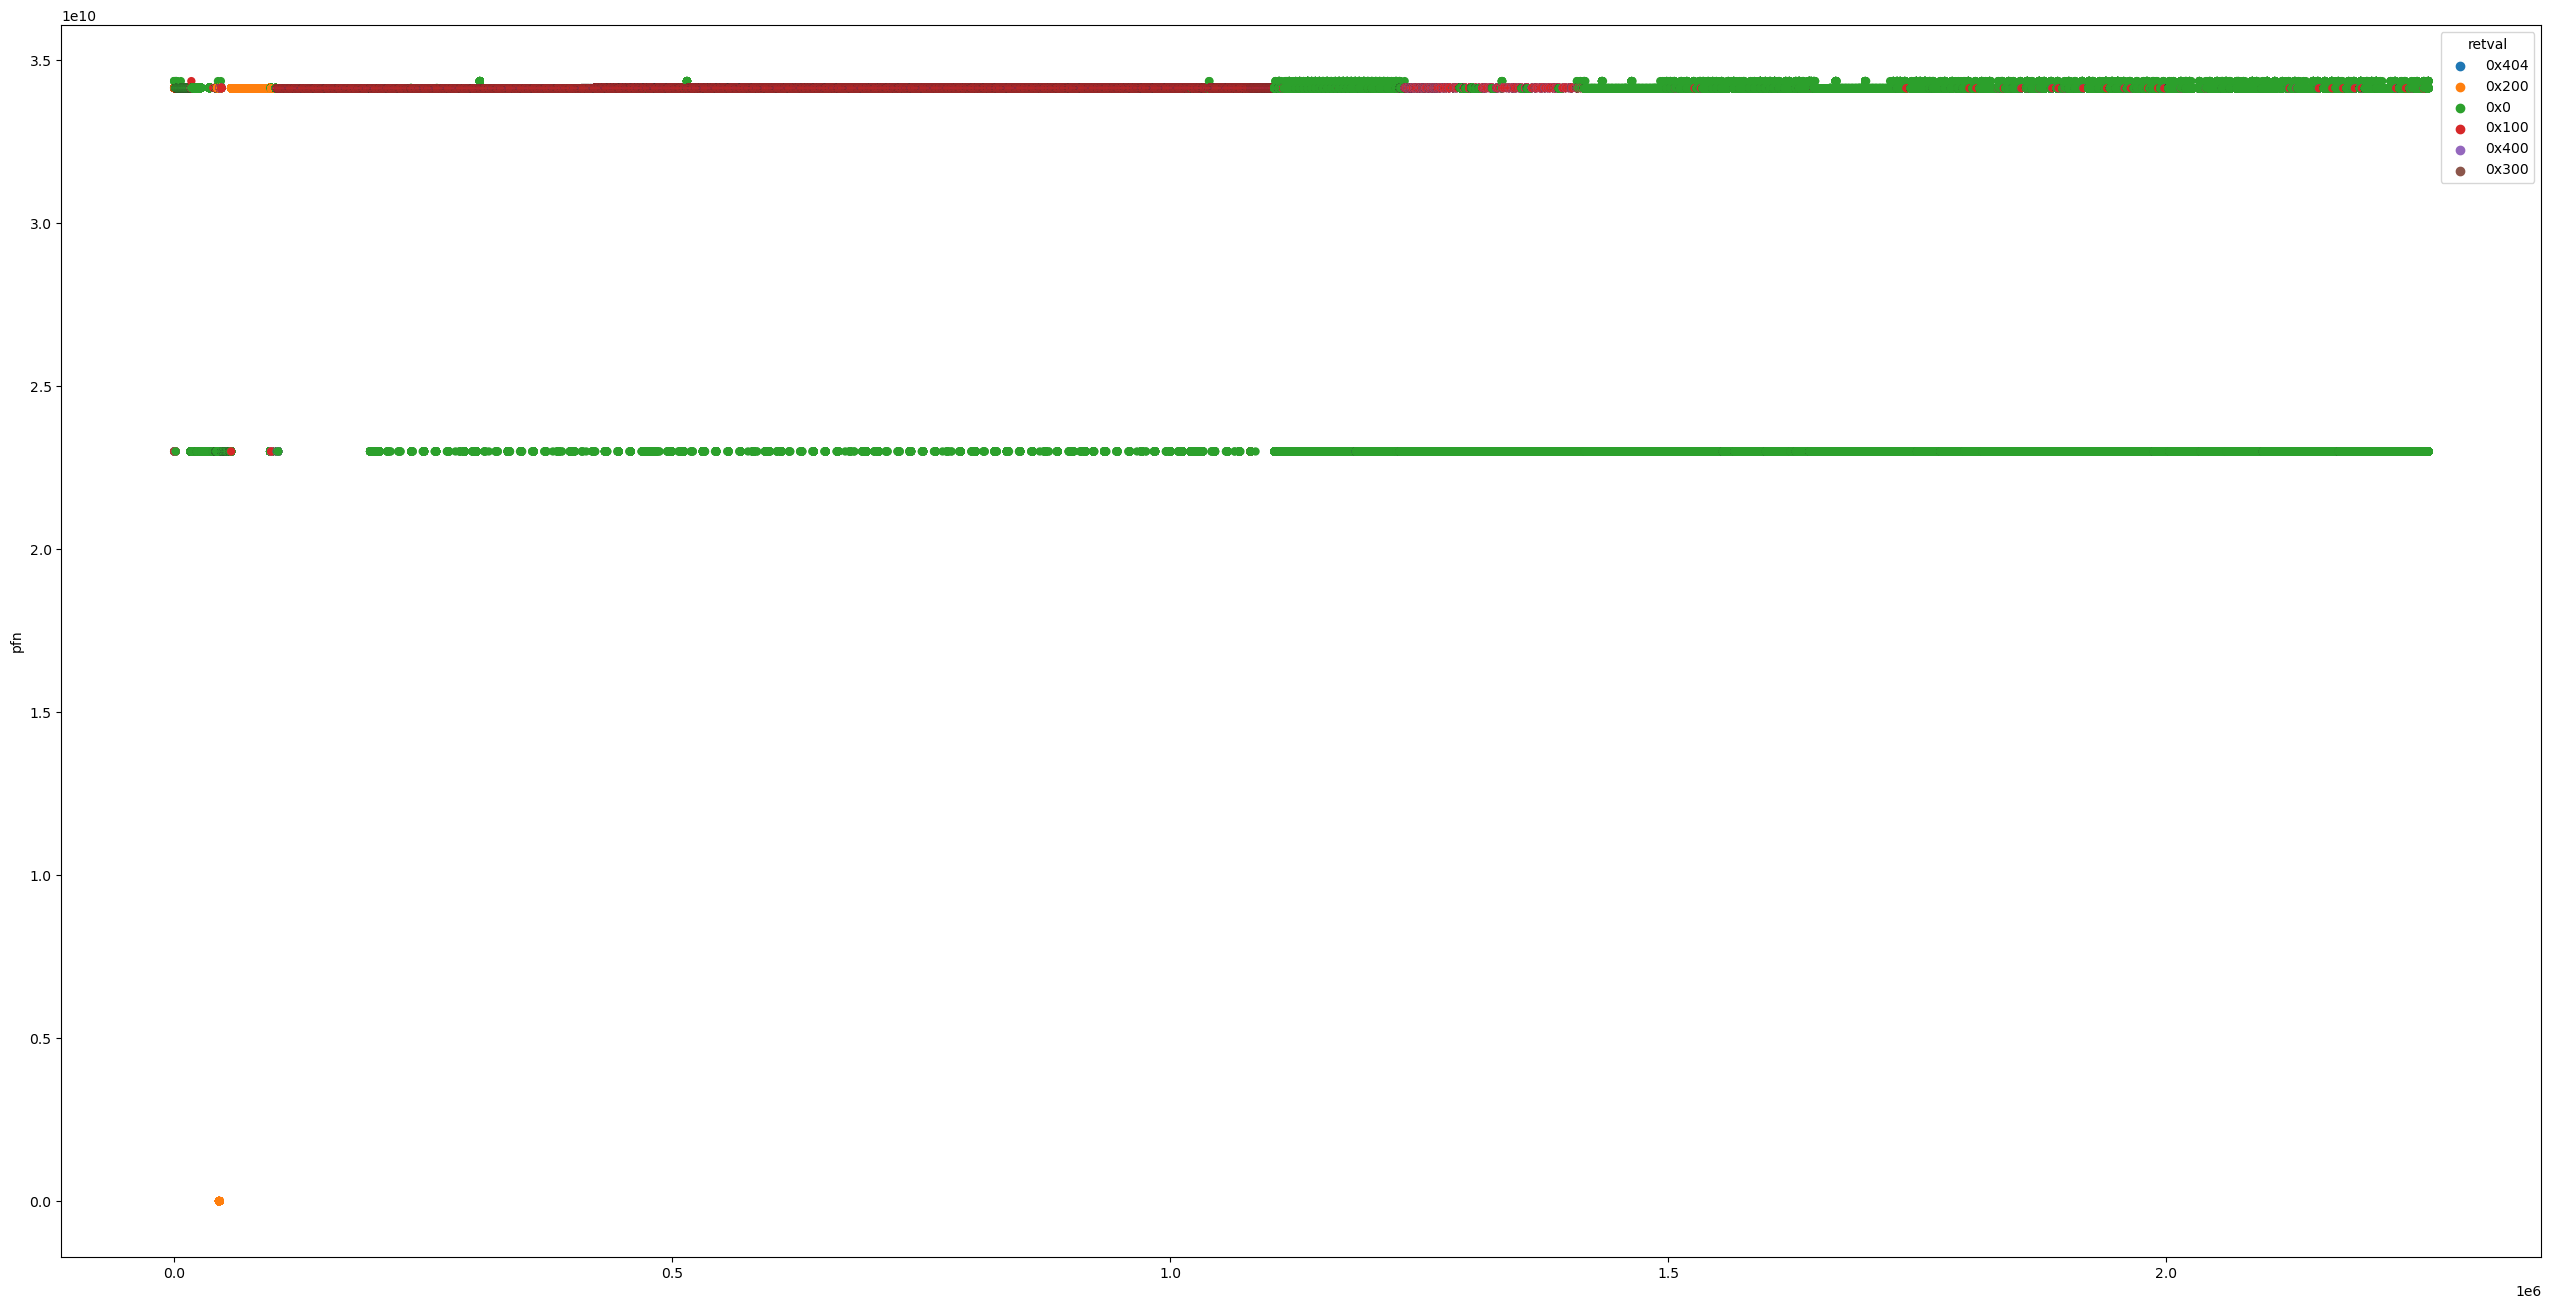

In [15]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(df)), y=df['pfn'], hue=df["retval"], linewidth=0)

In [16]:
kernel_fault = df[df["pfn"] > 3e10]
user_fault = df[(1e10 < df["pfn"]) & (df["pfn"] <= 3e10)]

<Axes: ylabel='pfn'>

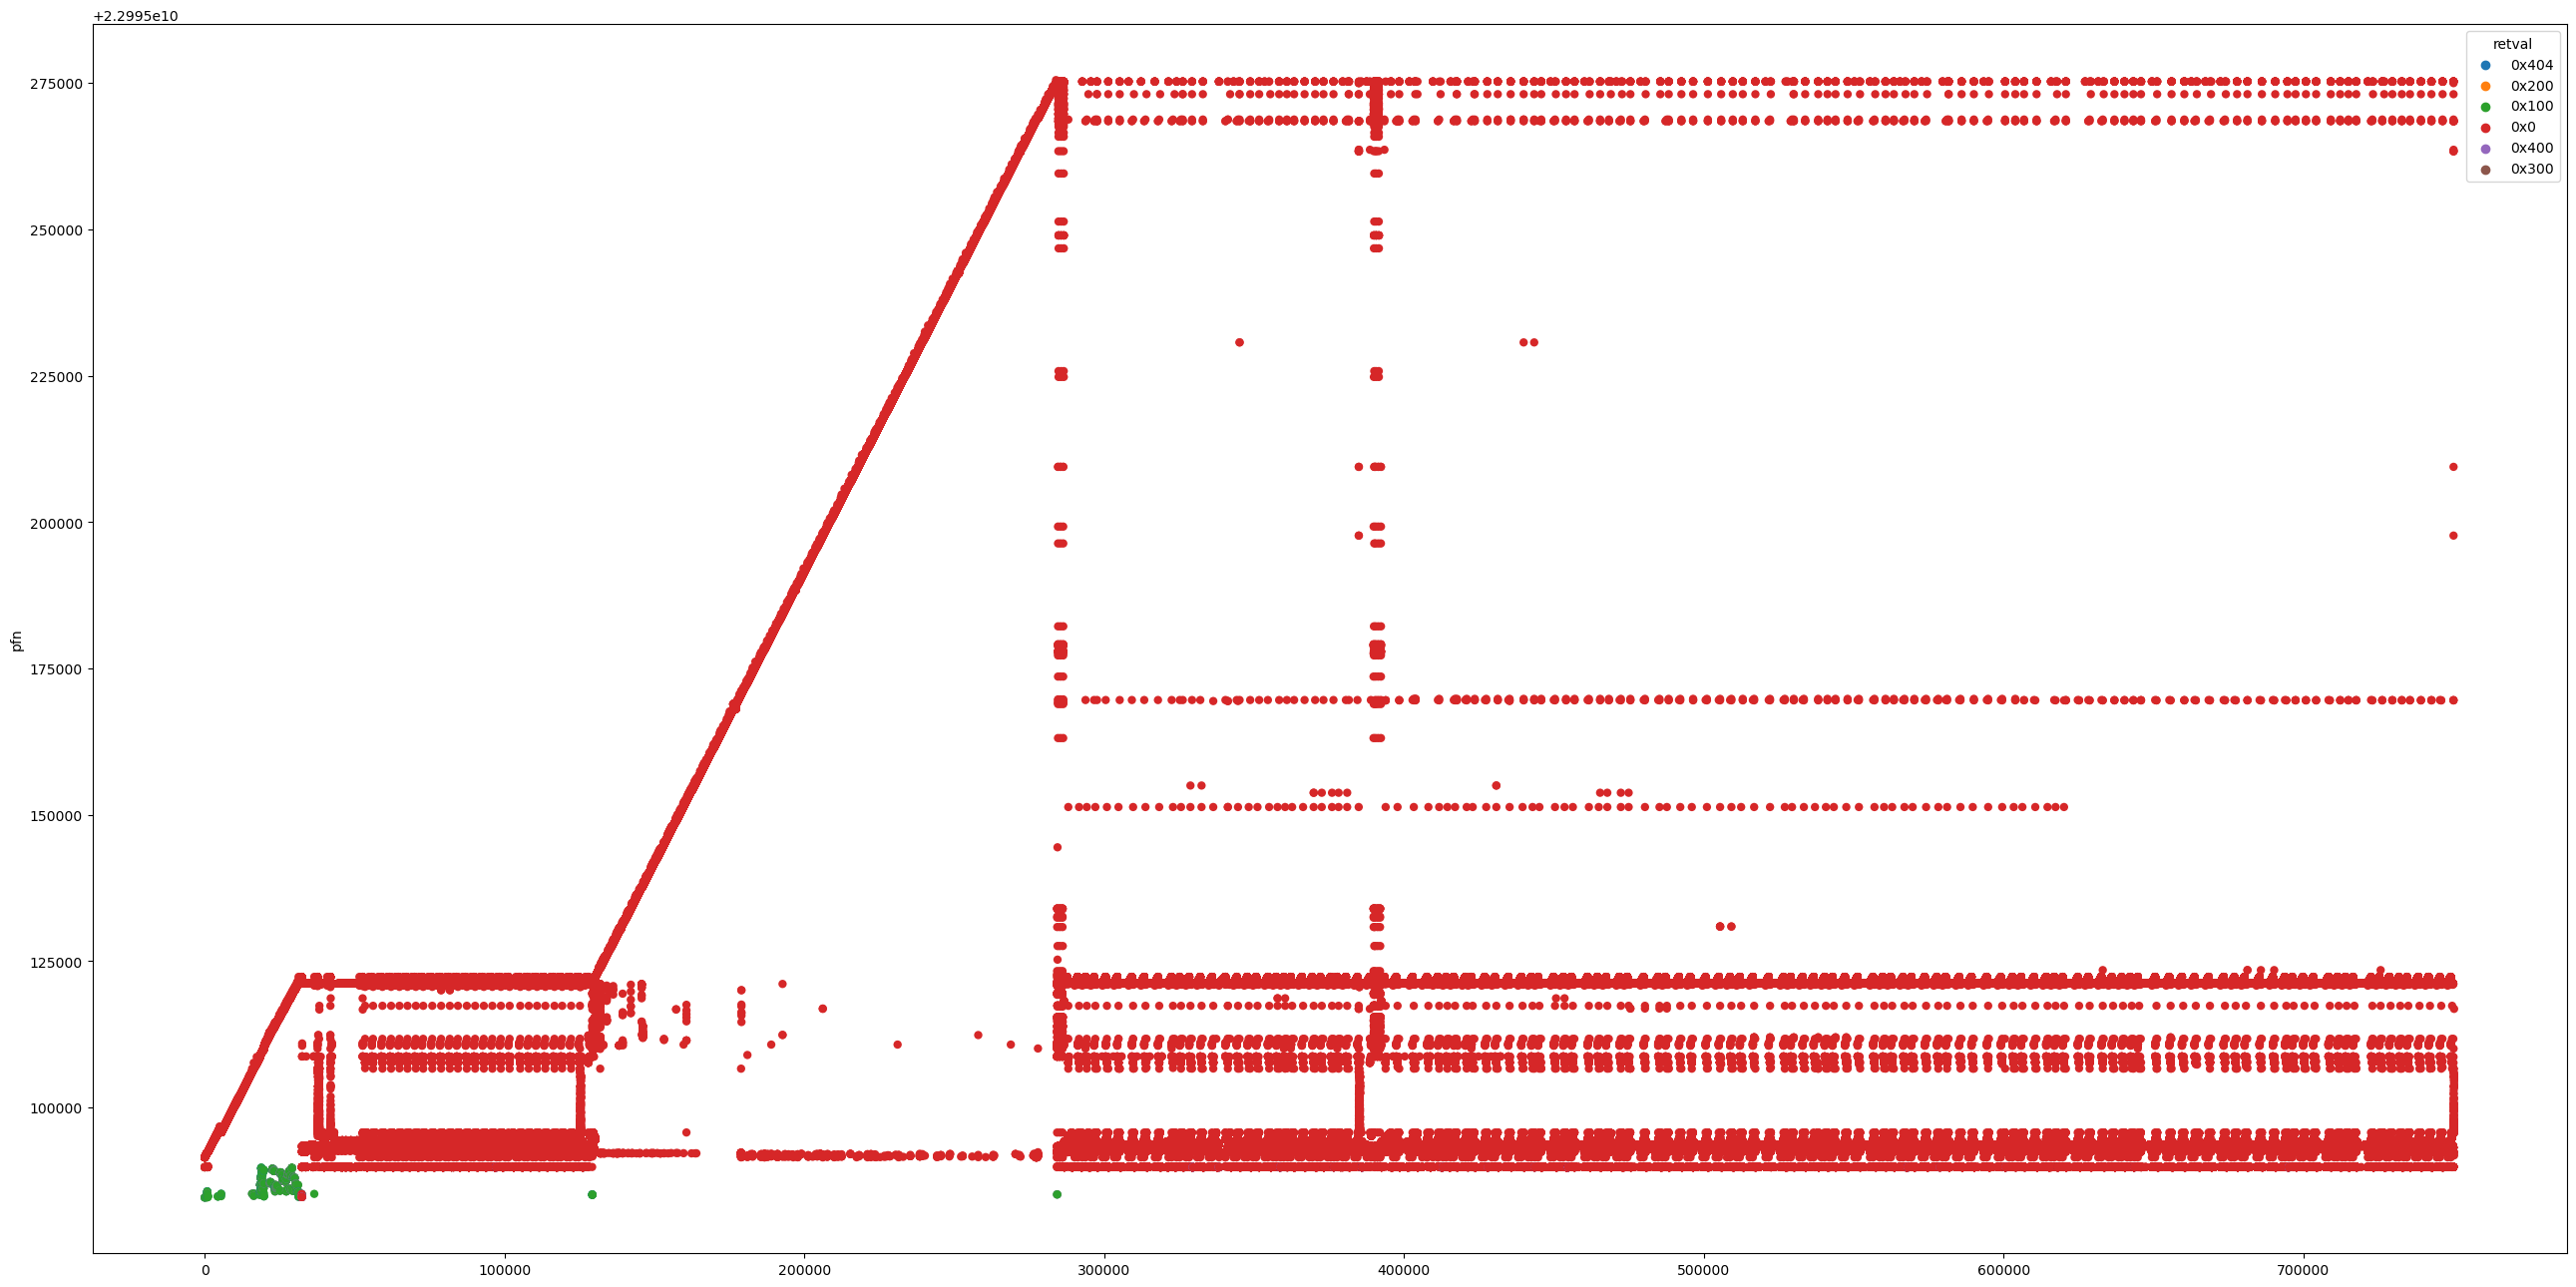

In [17]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault)), y=user_fault['pfn'], hue=user_fault["retval"], linewidth=0)

### 去除一下所有的0x0的fault，也就是非错误处理逻辑

In [18]:
no_zero_retval_fault = user_fault[user_fault["retval"] != "0x0"]

<Axes: ylabel='pfn'>

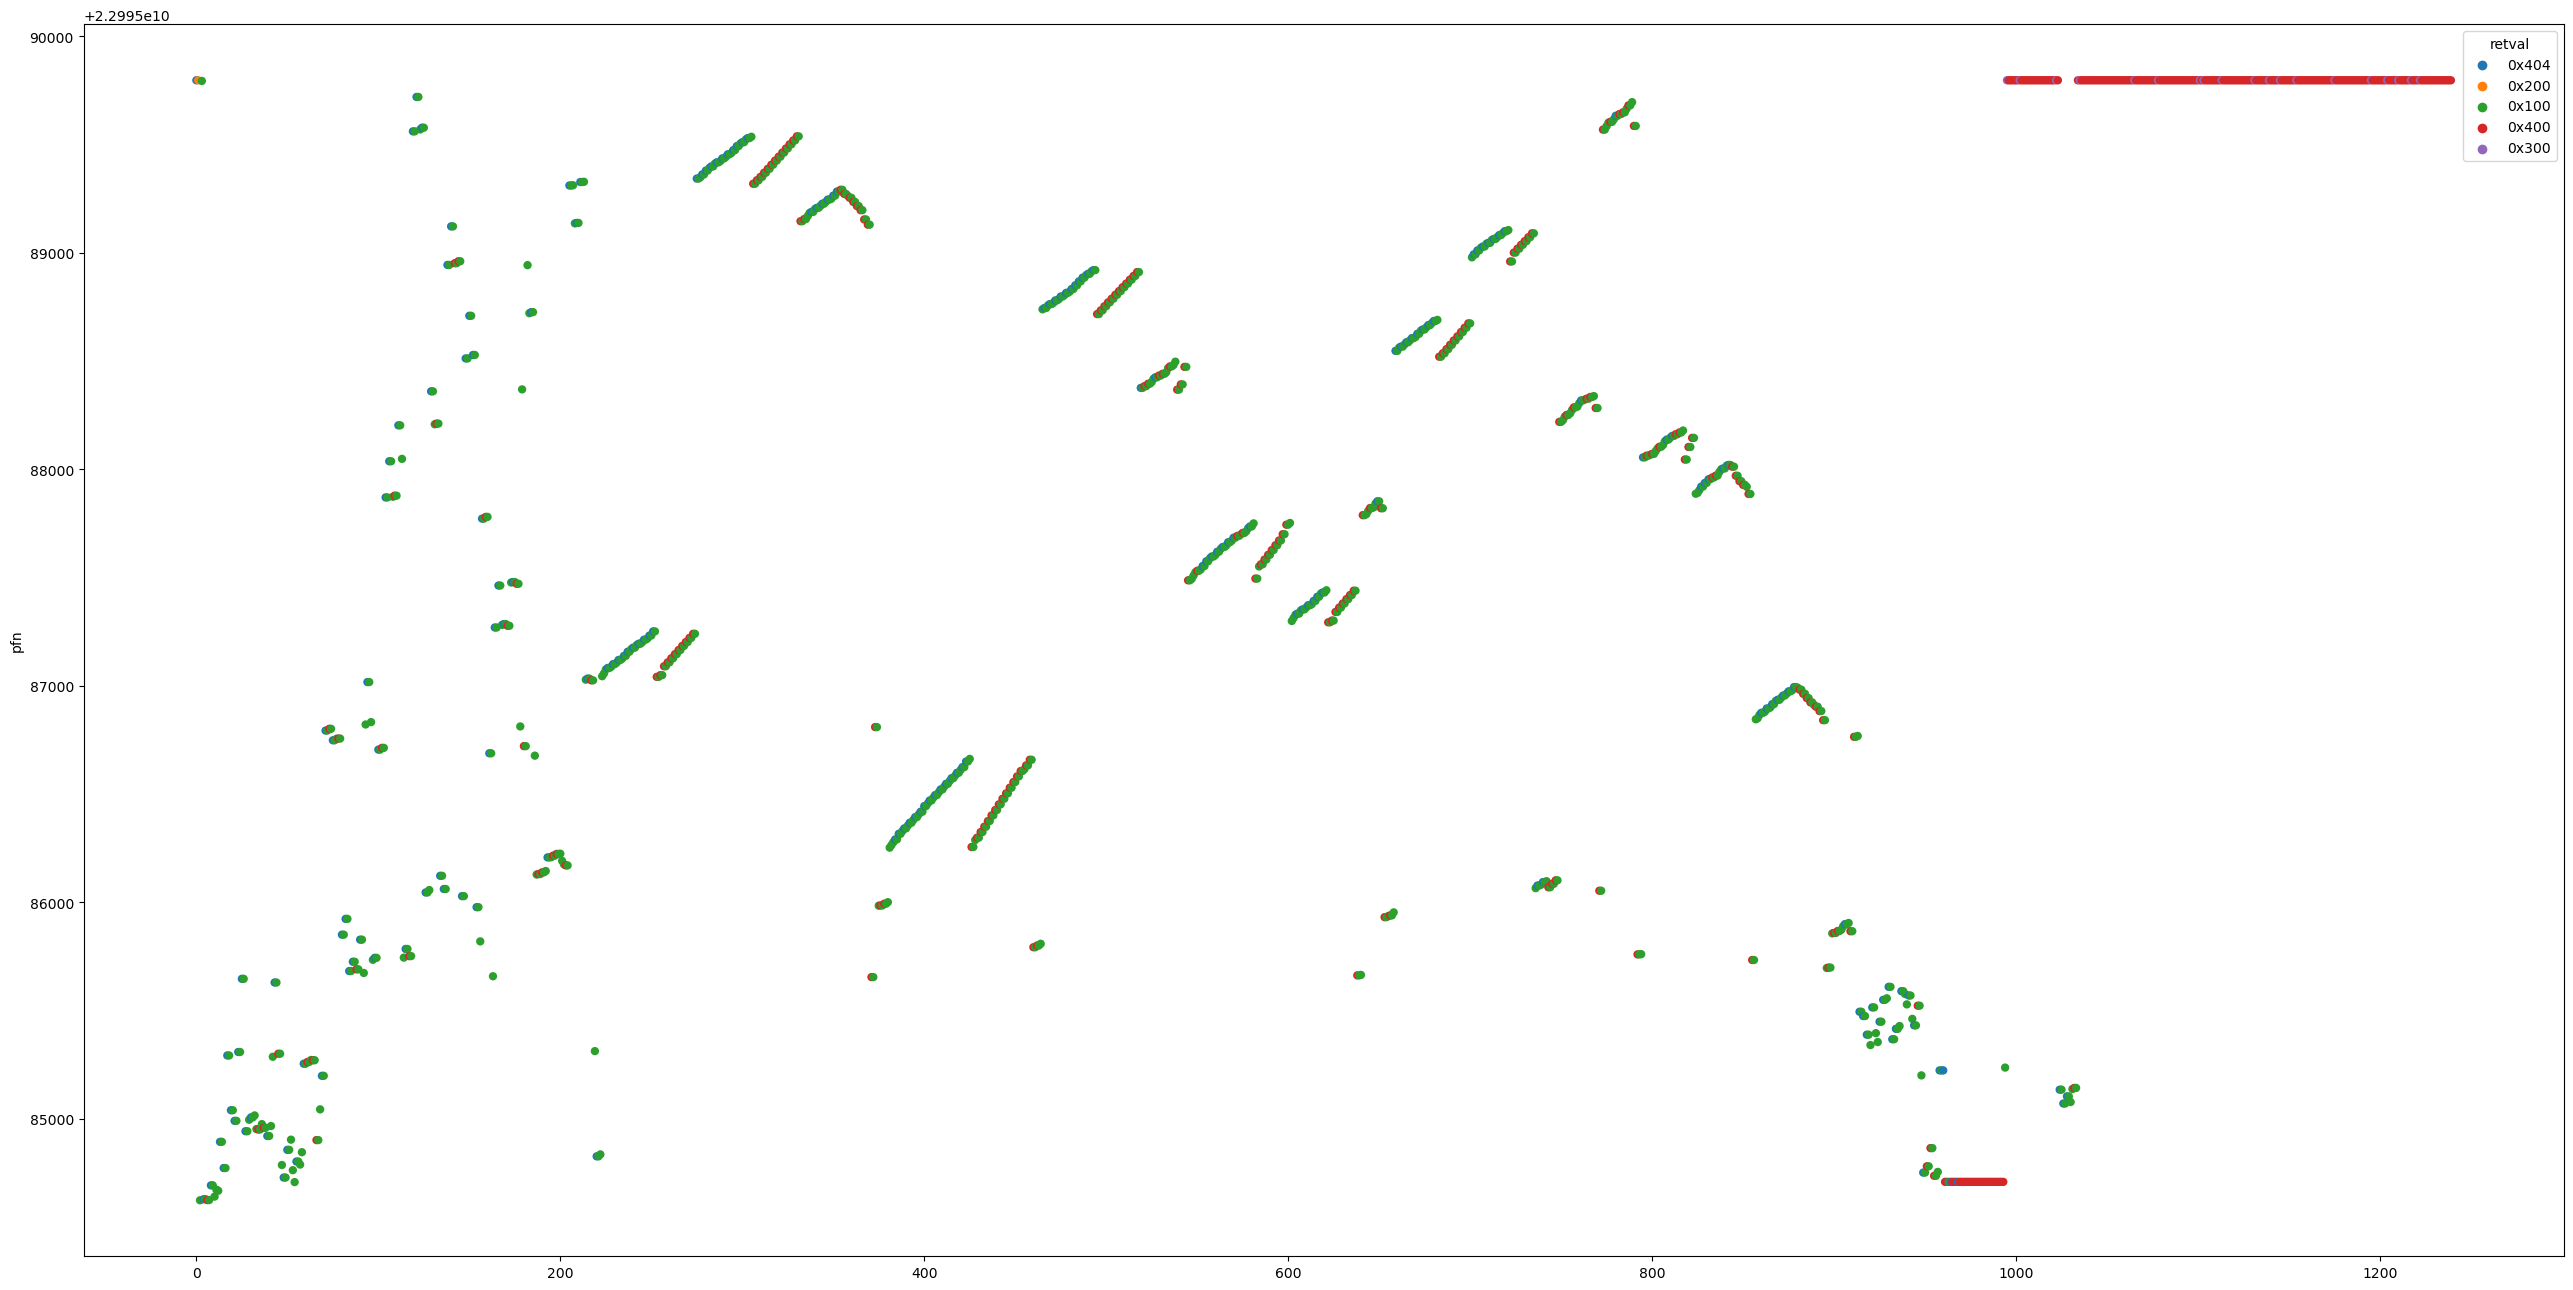

In [19]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(no_zero_retval_fault)), y=no_zero_retval_fault['pfn'], hue=no_zero_retval_fault["retval"], linewidth=0)

### 去除一下所有的0x100的fault，也就是NOPAGE

In [20]:
drop_zero_drop_no_page_retval_fault = user_fault[(user_fault["retval"] != "0x0") & (user_fault["retval"] != "0x100")]

<Axes: ylabel='pfn'>

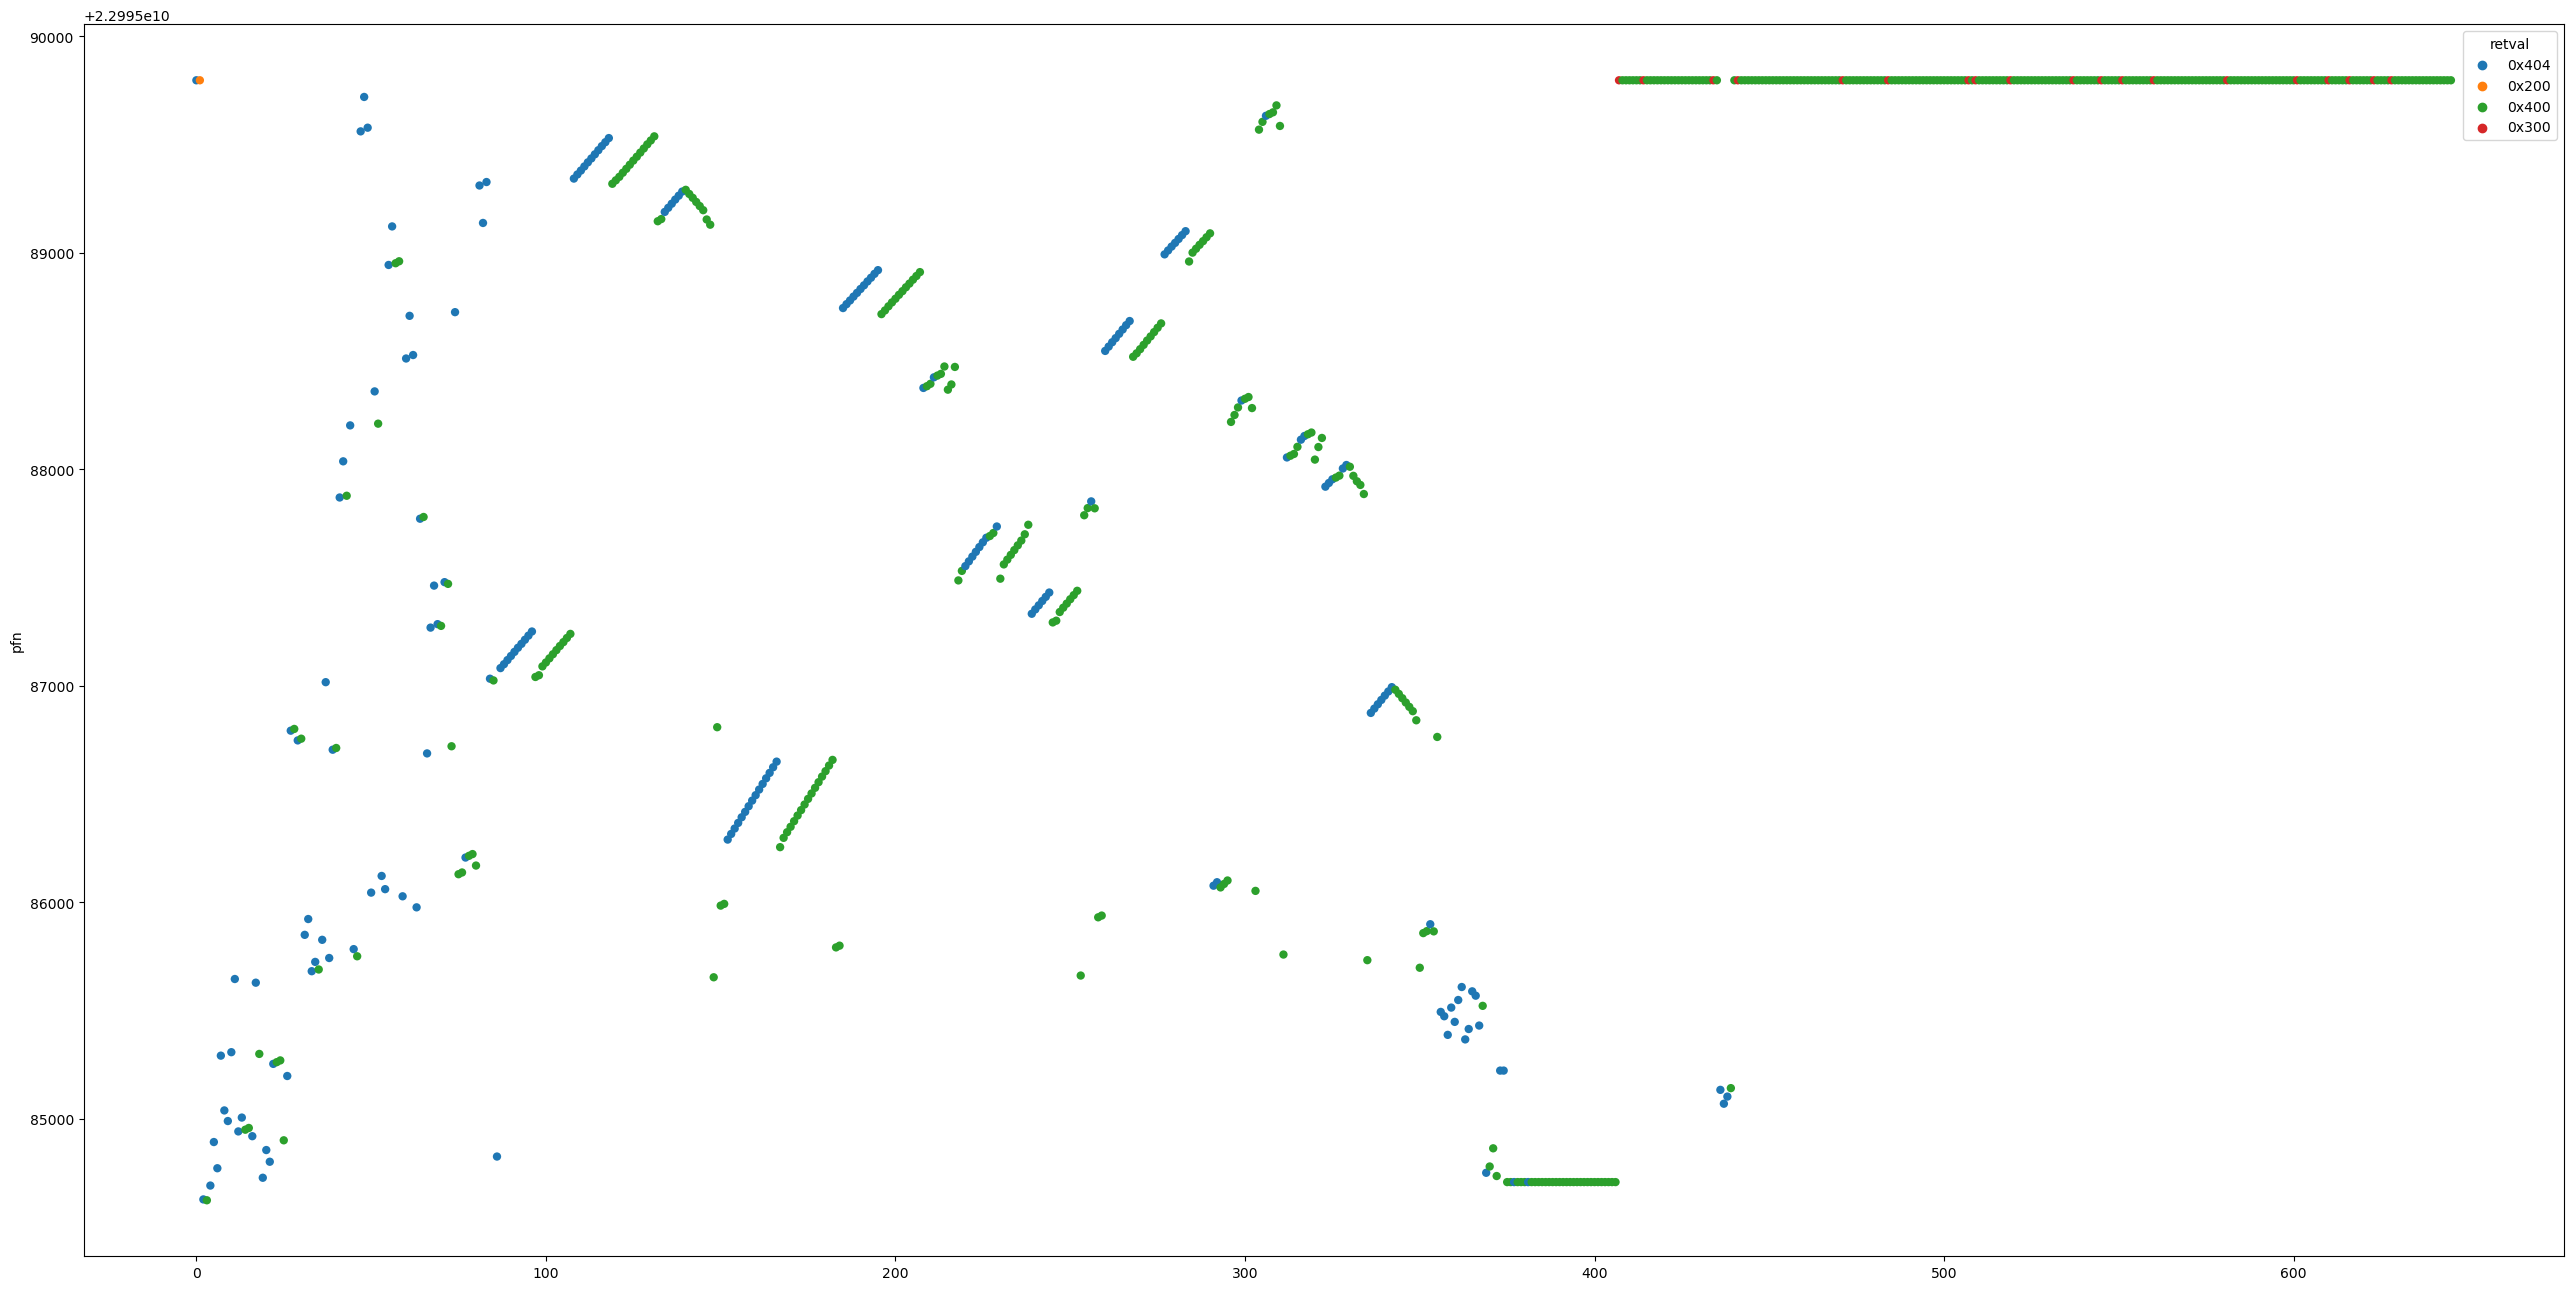

In [21]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(drop_zero_drop_no_page_retval_fault)), y=drop_zero_drop_no_page_retval_fault['pfn'], hue=drop_zero_drop_no_page_retval_fault["retval"], linewidth=0)

In [22]:
bak_df = df
bak_df["count"] = 1
time_cost = bak_df.groupby("retval").sum(["time", "count"])
time_cost["time"] = time_cost["time"].apply(lambda x: x/10e9)
time_cost

,time,pfn,count
retval,,,
0x0,0.760267,33053251542020141,1212696
0x100,0.532175,26975608807875016,790314
0x200,0.007799,1592886132254131,47174
0x300,0.000216,2826769922512,89
0x400,36.247488,6551040309992415,192025
0x404,8.434423,715871649676303,21028


In [44]:
df["time"].sum()

4798451721

### 只统计 major fault

In [25]:
fault_major_df = df[(df["retval"] == '0x404') | (df["retval"] == '0x400')]

<Axes: ylabel='pfn'>

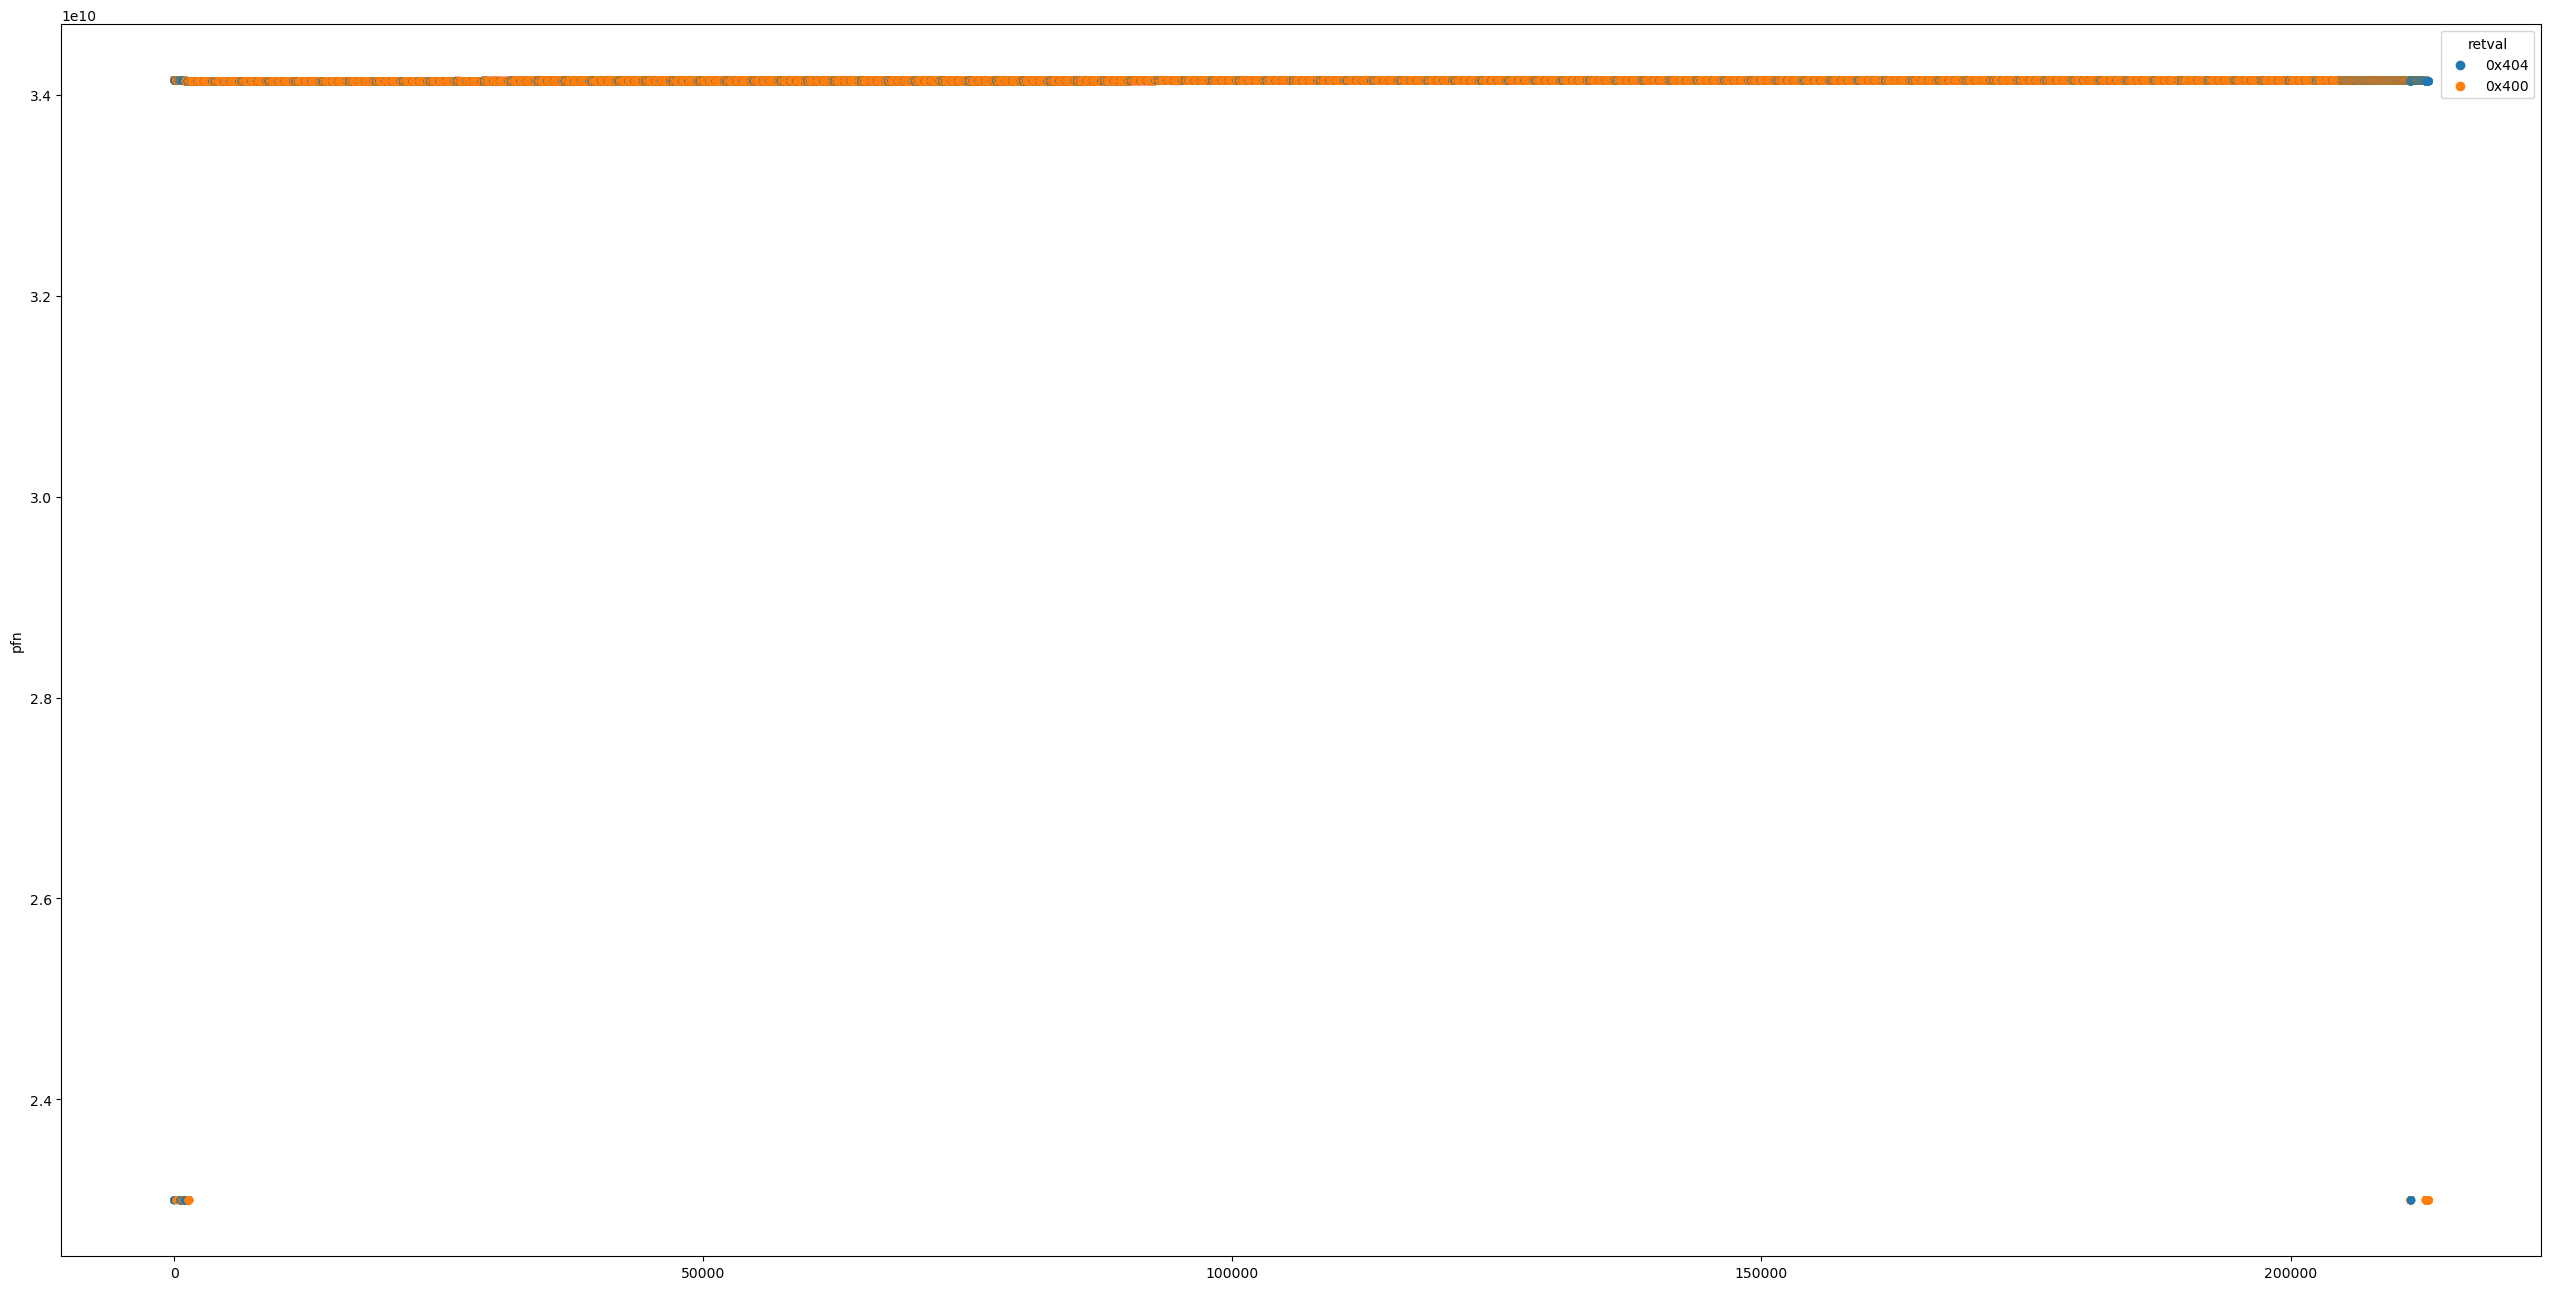

In [26]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(fault_major_df)), y=fault_major_df['pfn'], hue=fault_major_df["retval"], linewidth=0)

In [27]:
kernel_fault_major_df = fault_major_df[fault_major_df["pfn"] > 3e10]
user_fault_major_df = fault_major_df[fault_major_df["pfn"] <= 3e10]


In [28]:
print(len(kernel_fault_major_df))
print(len(user_fault_major_df))

212427
626


In [34]:
kernel_fault_major_df["time"].sum() / 1e9

446.706368469